
# Random Forest

dataset: https://www.kaggle.com/datasets/ozguraslank/brain-stroke-ct-dataset?resource=download

Reference used to read dataset:
* https://www.kaggle.com/code/ozguraslank/reading-brain-stroke-ct-dataset



In [19]:
#Data processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

#Modelling
from sklearn.ensemble import RandomForestClassifier #Random Forest Clasification
from sklearn.svm import SVC #C-support vector Clasification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
import os
import time



## Data processing 

In [20]:
path = 'Brain_Stroke_CT_Dataset/'

#Path de las imágenes
normal_path = path + "Normal" + "/" + "PNG" #Debe ser así pa q funcione tipo expresion regular
ischemia_path = path + "Ischemia" + "/" + "PNG"
bleeding_path = path + "Bleeding" + "/" + "PNG"

#Path de las máscaras
ischemia_mask_path = path + "Ischemia" + "/" + "OVERLAY"
bleeding_mask_path = path + "Bleeding" + "/" + "OVERLAY"

#Obtenemos todas las imágenes
normal_folder = os.listdir(normal_path)
ischemia_folder = os.listdir(ischemia_path)
bleeding_folder = os.listdir(bleeding_path)

#Obtenemos todas las máscaras
ischemia_mask_folder = os.listdir(ischemia_mask_path)
bleeding_mask_folder = os.listdir(bleeding_mask_path)


#Mostramos cantidad de datos por clase para ver desbalance
size_normal = len(normal_folder)
size_ischemia = len(ischemia_folder)
size_bleeding = len(bleeding_folder)
print("Normal:", size_normal)
print("Ischemia:", size_ischemia)
print("Bleeding:", size_bleeding)


Normal: 4427
Ischemia: 1130
Bleeding: 1093


In [21]:
def process_image(file_path, dim, scale):
    img = Image.open(file_path)
    img = img.convert(scale) #Escala de grises o RGB
    img = img.resize(dim) #Reescalamos
    img = np.array(img)
    return img #.flatten()

In [ ]:
#Almacenamos todas las imágenes
data = []
dim = (256, 256) #resize

folders = [normal_folder, ischemia_folder, bleeding_folder]
paths = [normal_path, ischemia_path, bleeding_path]

for i in range(len(folders)):

    #Recorremos todos los archivos de la carpeta y path i 
    for file_name in folders[i]:
        img = process_image(paths[i] + "/" + file_name, dim, 'L') #L = escala de grises
        data.append(img)

#También almacenamos las máscaras
mask_folders = [ischemia_mask_folder, bleeding_mask_folder]
mask_paths = [ischemia_mask_path, bleeding_mask_path]
masks = []
for i in range(len(mask_folders)):

    #Recorremos todos los archivos de la carpeta y path i
    counter = 0
    for file_name in mask_folders[i]:

        if i == 0 and counter == 534:
            print(file_name)

        img = process_image(mask_paths[i] + "/" + file_name, dim, "RGB")
        masks.append(img)
        counter += 1


13445.png


In [23]:
#Verificamos dimensión de los datos
data = np.array(data)
data.shape

(6650, 256, 256)

In [24]:
#Creamos el vector de labels
y = np.zeros(6650)
y[:size_normal] = 0 #Normal label [0:4427]
y[size_normal:size_normal+size_ischemia] = 1 #Ishcemia label [4427: 5557]
y[size_normal+size_ischemia:] = 2   #bleeding label [5557:]
y.shape


(6650,)

### Image examples

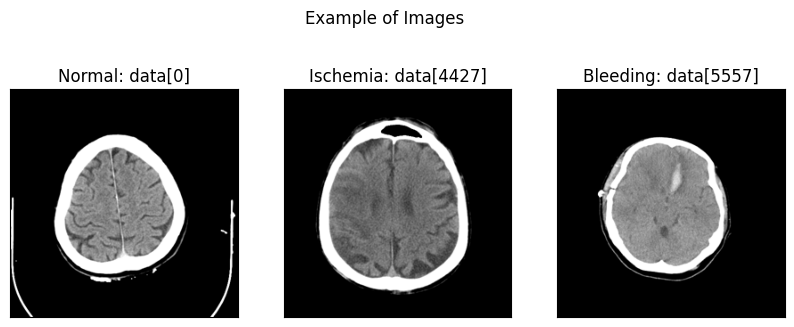

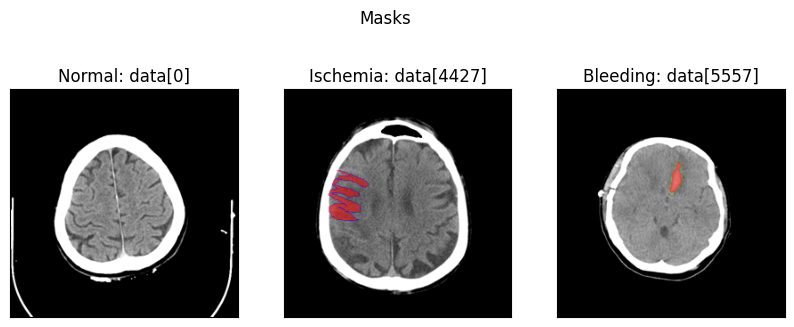

In [25]:
#Mostrmoas una imágen de ejemplo (para ver si el vector y está bien)
f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Example of Images")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(data[0].reshape(dim), cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(data[4427].reshape(dim), cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(data[5557].reshape(dim), cmap="gray")
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


#We will also show the masks of the above pictures (manual)
data0_path =    normal_path    + "/10000.png"
data4427_path = ischemia_mask_path  + "/10003.png"
data5557_path = bleeding_mask_path  + "/10002.png"

mask_data0 = process_image(data0_path, dim, "RGB")
mask_data4427 = process_image(data4427_path, dim, "RGB")
mask_data5557 = process_image(data5557_path, dim, "RGB")

f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Masks")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(mask_data0.reshape((dim[0], dim[1],3)))
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(mask_data4427.reshape((dim[0], dim[1],3)))
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(mask_data5557.reshape((dim[0], dim[1],3)))
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


In [26]:
#data.shape
data.resize(6650,dim[0]*dim[0])
data.shape

(6650, 65536)

# Entrenamiento y Resultados


In [27]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

#Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Train
clf = RandomForestClassifier(n_estimators=100, random_state=42)

start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
print("Training time (min):", (end_time-start_time)/60)

start_time = time.time()
y_pred_rdf = clf.predict(X_test)
end_time = time.time()
print("Prediction time (min):", (end_time-start_time)/60)


print(classification_report(y_test, y_pred_rdf))

Training time (min): 1.6314844846725465
Prediction time (min): 0.006997990608215332
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       907
         1.0       0.98      0.55      0.70       218
         2.0       0.95      0.47      0.63       205

    accuracy                           0.84      1330
   macro avg       0.92      0.67      0.74      1330
weighted avg       0.87      0.84      0.83      1330



# Explicabilidad

In [29]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from ipywidgets import interact
from skimage.segmentation import quickshift

In [31]:
data = np.array(data)
masks = np.array(masks)

In [ ]:
#Slicer to choose an image to explain
#Slicer to choose an image to explain = 10
def show_image(index):
    
    img_to_explain = np.resize(data[index, :], dim)


    if index >= 4427 and index < 5557:
        type = "Ischemia"
        mask_index = index - len(normal_folder)
    
    if index >= 5557:
        type = "Bleeding"
        mask_index = index - len(normal_folder)
    
    f, axes = plt.subplots(1, 2)
    f.set_figheight(4)
    f.set_figwidth(10)
    f.suptitle("Masks " + type)

    axes[0].imshow(img_to_explain, cmap="gray")
    axes[0].set_xticks([])
    axes[0].set_yticks([])


    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].imshow(masks[mask_index].reshape(dim[0], dim[0], 3))
    plt.show()


#show_image(index)
interact(show_image, index=(len(normal_folder), 6549, 1))

interactive(children=(IntSlider(value=5488, description='index', max=6549, min=4427), Output()), _dom_classes=…

<function __main__.show_image(index)>

In [85]:
index_to_explain_ischemia = 4558
index_to_explain_bleeding = 5882

### Ischemia explanation

131


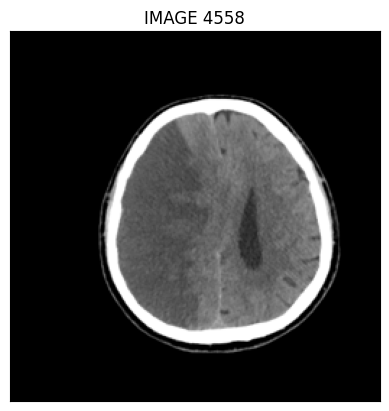

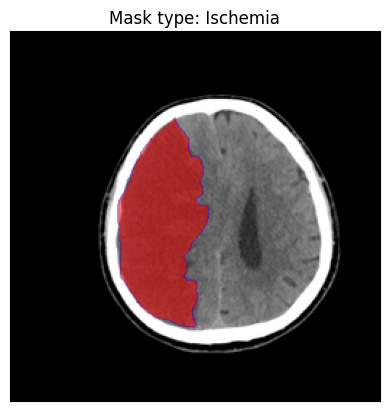

In [43]:
explainer = lime_image.LimeImageExplainer()
index = index_to_explain_ischemia

#Image
img_to_explain = np.resize(data[index, :], dim)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.title("IMAGE " + str(index))
plt.imshow(img_to_explain, cmap="gray")

#Mask
mask_index = 0
type = "Not defined"
if index >= 4427 and index < 5527:
    type =  "Ischemia"
    mask_index = index - len(normal_folder)

elif index >= 5527:
    type = "bleeding"
    mask_index = index -len(normal_folder) - len(ischemia_folder)

print(mask_index)

plt.figure()
plt.title("Mask type: " + type)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[mask_index].reshape((dim[0], dim[1], 3)))
plt.show()


Esto está medio xd porque predice que es mas probable que sea normal, lo segundo que sea bleeding y por ultimo ischemia 

In [71]:
clf.classes_

array([0., 1., 2.])

In [48]:
#Lime entragará imágenes perturbadas al modelo y tiene que otorgar un score a cada clase
print(clf.predict_proba(img_to_explain.flatten().reshape(1, -1)))

#Lime entregará imagenes perturbadas que tenemos que procesar antes de pasarselo a nuestro svm
def predict_rf(images):
   
    #Lime copia las imagenes a 3 canales rgb
    processed = []
    for img in images:
        processed.append(img[:, :, 0].flatten())
    X = np.stack(processed)
    return clf.predict_proba(X)

[[0.64 0.17 0.19]]


In [65]:
# Cambiamos el segmentador para que tenga más superpixeles y se ajuste al sector con ischemia
segmenter = lambda image: quickshift(
    image,
    kernel_size=5,   
    max_dist=200,     
    ratio=3       
)

In [66]:
explanation = explainer.explain_instance(
    img_to_explain,
    predict_rf,
    top_labels=3,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmenter #Borrar esto para default
)

  0%|          | 0/1000 [00:00<?, ?it/s]

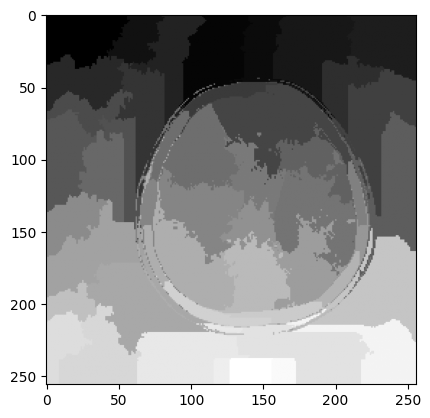

In [67]:
#Mostramos los super pixeles
plt.imshow(explanation.segments, cmap="gray")

In [ ]:
#0: Normal
#1: Ischemia
#2: Bleeding
explanation.top_labels

[np.int64(0), np.int64(2), np.int64(1)]

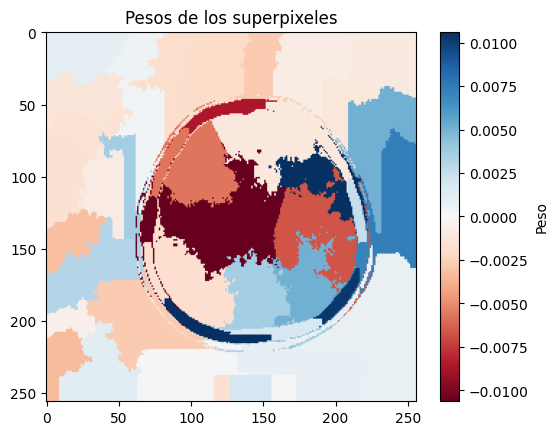

In [ ]:
# Seleccionar el índice de la clase que verdaderamente es (posicion 2)
top_class_index = explanation.top_labels[2]

# Extraer los pesos asociados a cada superpixel de la explicación
class_weights = explanation.local_exp[top_class_index]

# Crear un diccionario que mapea los superpixeles a sus pesos
superpixel_weights = dict(class_weights)

# Mapear los pesos a los superpixeles para generar un mapa de calor
heatmap = np.vectorize(superpixel_weights.get)(explanation.segments)

plt.figure()
plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar(label='Peso')
plt.title('Pesos de los superpixeles')
plt.show()

### Bleeding explanation

1455


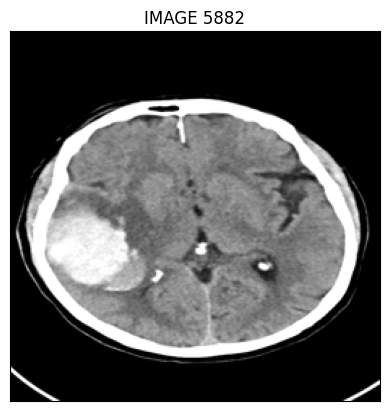

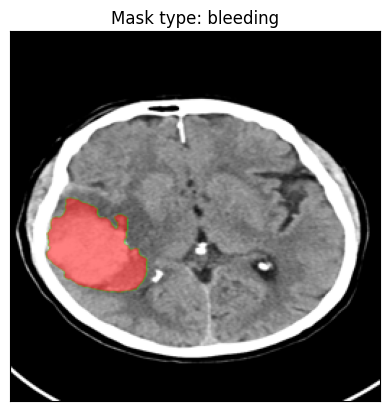

In [86]:
explainer = lime_image.LimeImageExplainer()
index = index_to_explain_bleeding

#Image
img_to_explain = np.resize(data[index, :], dim)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.title("IMAGE " + str(index))
plt.imshow(img_to_explain, cmap="gray")

#Mask
mask_index = 0
type = "Not defined"
if index >= 4427 and index < 5527:
    type =  "Ischemia"
    mask_index = index - len(normal_folder)

elif index >= 5527:
    type = "bleeding"
    mask_index = index -len(normal_folder)

print(mask_index)

plt.figure()
plt.title("Mask type: " + type)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[mask_index].reshape((dim[0], dim[1], 3)))
plt.show()


In [87]:
print(clf.predict_proba(img_to_explain.flatten().reshape(1, -1)))
#Aqui al menos el segundo más probable es bleeding

[[0.5  0.17 0.33]]


In [88]:
segmenter = lambda image: quickshift(
    image,
    kernel_size=5,   
    max_dist=200,     
    ratio=3       
)

explanation = explainer.explain_instance(
    img_to_explain,
    predict_rf,
    top_labels=3,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmenter #Borrar esto para default
)

  0%|          | 0/1000 [00:00<?, ?it/s]

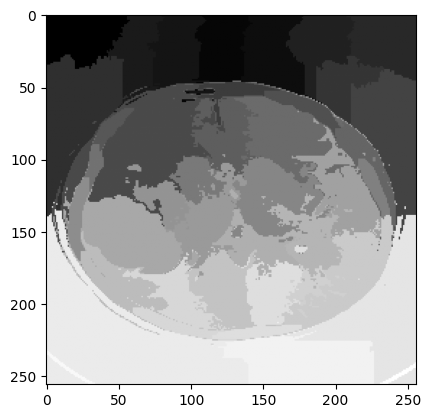

In [89]:
#Mostramos los super pixeles
plt.imshow(explanation.segments, cmap="gray")

In [90]:
#0:normal
#1: Ischemia
#2: Bleeding
explanation.top_labels


[np.int64(0), np.int64(2), np.int64(1)]

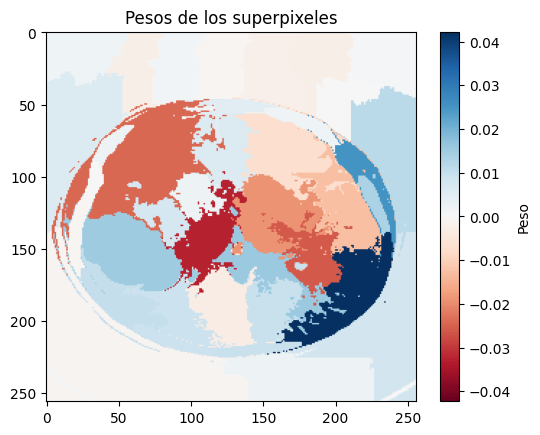

In [91]:
# Seleccionar el índice de la clase que verdaderamente es para explicarla
top_class_index = explanation.top_labels[1]

# Extraer los pesos asociados a cada superpixel de la explicación
class_weights = explanation.local_exp[top_class_index]

# Crear un diccionario que mapea los superpixeles a sus pesos
superpixel_weights = dict(class_weights)

# Mapear los pesos a los superpixeles para generar un mapa de calor
heatmap = np.vectorize(superpixel_weights.get)(explanation.segments)

plt.figure()
plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar(label='Peso')
plt.title('Pesos de los superpixeles')
plt.show()